# Chapter 15 How to Grid Search Deep Learning Models for Univariate Forecasting

In this tutorial, you will discover how to develop a framework to grid search hyperparameters for deep learning models. After completing this tutorial, you will know:
- How to develop a generic grid searching framework for tuning model hyperparameters.
- How to grid search hyperparameters for a Multilayer Perceptron model on the airline
passengers univariate time series forecasting problem.
- How to adapt the framework to grid search hyperparameters for convolutional and long short-term memory neural networks.
Let’s get started.


## 15.1 Tutorial Overview
This tutorial is divided into five parts; they are:
1. Time Series Problem
2. Grid Search Framework
3. Multilayer Perceptron Model
4. Convolutional Neural Network Model
5. Long Short-Term Memory Network Model

## 15.2 Time Series Problem

In this tutorial we will focus on one dataset and use it as the context to demonstrate the development of a grid searching framework for range of deep learning models for univariate time series forecasting. 

We will use the monthly airline passenger dataset as this context as it includes the complexity of both trend and seasonal elements. The monthly airline passenger dataset summarizes the monthly total number of international passengers in thousands on for an airline from 1949 to 1960.

(144, 1)


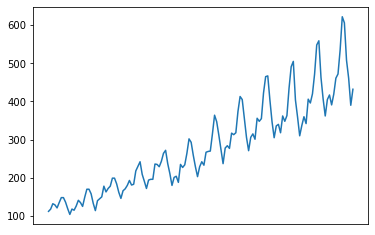

In [1]:
# load and plot monthly airline passengers dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

## 15.3 Develop a Grid Search Framework
In this section, we will develop a grid search test harness that can be used to evaluate a range of hyperparameters for different neural network models, such as MLPs, CNNs, and LSTMs. This section is divided into the following parts:
1. Train-Test Split
2. Series as Supervised Learning 
3. Walk-Forward Validation
4. Repeat Evaluation
5. Summarize Performance
6. Worked Example

### 15.3.1 Train-Test Split

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

### 15.3.2 Series as Supervised Learning

In [29]:
import numpy as np
from pandas import DataFrame
from pandas import concat

a = np.arange(1,10,1)
a

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [34]:
# 前4列为输入数据，后两列为输出数据
series_to_supervised(a,4,2)

array([[1., 2., 3., 4., 5., 6.],
       [2., 3., 4., 5., 6., 7.],
       [3., 4., 5., 6., 7., 8.],
       [4., 5., 6., 7., 8., 9.]])

In [41]:
# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

In [45]:
difference(series_to_supervised(a,4,2),1)

[array([1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1.])]

### 15.3.3 Walk-Forward Validation

In [4]:
# fit a model
def model_fit(train, config):
    return None

In [5]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    return 0.0

In [6]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [9]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

### 15.3.4 Repeat Evaluation

In [10]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)] # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

### 15.3.5 Grid Search

In [37]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

### 15.3.6 Worked Example

In [40]:
# grid search persistence models for monthly airline passengers dataset
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    return None

# forecast with a pre-fit model
def model_predict(model, history, offset):
    return history[-offset]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)] # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores  = [repeat_evaluate(data, n_test, cfg) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

if __name__ == '__main__':
    # define dataset
    series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 12
    # model configs
    cfg_list = [1, 6, 12, 24, 36]
    # grid search
    scores = grid_search(data, cfg_list, n_test) 
    print('done')
    # list top 10 configs
    for cfg, error in scores[:10]:
        print(cfg, error)

 > 27.000
 > 27.000
 > 27.000
 > 27.000
 > 27.000
 > 27.000
 > 27.000
 > 27.000
 > 27.000
 > 27.000
> Model[12] 27.000
 > 48.544
 > 48.544
 > 48.544
 > 48.544
 > 48.544
 > 48.544
 > 48.544
 > 48.544
 > 48.544
 > 48.544
> Model[12] 48.544
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
> Model[12] 50.708
 > 49.987
 > 49.987
 > 49.987
 > 49.987
 > 49.987
 > 49.987
 > 49.987
 > 49.987
 > 49.987
 > 49.987
> Model[12] 49.987
 > 41.979
 > 41.979
 > 41.979
 > 41.979
 > 41.979
 > 41.979
 > 41.979
 > 41.979
 > 41.979
 > 41.979
> Model[12] 41.979
done
12 27.0
12 41.97916149710473
12 48.54379466007988
12 49.986664888414666
12 50.708316214732804


## 15.4 Multilayer Perceptron Model

There are many aspects of the MLP that we may wish to tune. We will define a very simple model with one hidden layer and define five hyperparameters to tune. They are:
- n input: The number of prior inputs to use as input for the model (e.g. 12 months). 
- n nodes: The number of nodes to use in the hidden layer (e.g. 50).
- n epochs: The number of training epochs (e.g. 1000).
- n batch: The number of samples to include in each minibatch (e.g. 32).
- n diff: The difference order (e.g. 0 or 12).

In [ ]:
# by no means == not at all

一旦模型拟合，我们就可以用它来进行预测。如果数据存在差分，则必须反转差分才能预测模型。这涉及将历史相对偏移处的值添加回模型预测的值。

In [ ]:
# invert difference
correction = 0.0
if n_diff > 0:
    correction = history[-n_diff]
...
# correct forecast if it was differenced
return correction + yhat[0]

In [49]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input)) 
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

**The complete example is listed below.**

In [62]:
# grid search mlps for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
    history = difference(history, n_diff)
    # shape input for model
    x_input = array(history[-n_input:]).reshape((1, n_input))
    # make forecast
    yhat = model.predict(x_input, verbose=0)
    # correct forecast if it was differenced
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)] # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores  = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs)) 
    return configs

if __name__ == '__main__':
    # define dataset
    series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 12
    # model configs
    cfg_list = model_configs()
    # grid search
#     print(data,cfg_list,n_test)
    scores = grid_search(data, cfg_list, n_test) 
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

Total configs: 8
 > 479.897
 > 480.664
 > 479.939
 > 480.827
 > 479.643
 > 481.203
 > 480.250
 > 480.988
 > 479.461
 > 481.192
> Model[[12, 50, 100, 1, 0]] 480.406
 > 20.470
 > 19.559
 > 19.659
 > 20.019
 > 20.702
 > 22.057
 > 24.034
 > 19.239
 > 21.567
 > 21.152
> Model[[12, 50, 100, 1, 12]] 20.846
 > 481.872
 > 481.858
 > 481.877
 > 481.838
 > 481.864
 > 481.855
 > 481.886
 > 481.902
 > 481.897
 > 481.883
> Model[[12, 50, 100, 150, 0]] 481.873
 > 19.088
 > 19.660
 > 18.486
 > 21.087
 > 18.418
 > 18.423
 > 21.553
 > 20.367
 > 20.878
 > 19.587
> Model[[12, 50, 100, 150, 12]] 19.755
 > 480.330
 > 480.406
 > 481.043
 > 480.831
 > 479.957
 > 480.657
 > 479.984
 > 480.707
 > 480.915
 > 481.008
> Model[[12, 100, 100, 1, 0]] 480.584
 > 16.758
 > 19.102
 > 19.817
 > 17.657
 > 18.887
 > 18.423
 > 20.173
 > 21.128
 > 19.668
 > 19.272
> Model[[12, 100, 100, 1, 12]] 19.089
 > 481.844
 > 481.878
 > 481.903
 > 481.899
 > 481.881
 > 481.890
 > 481.888
 > 481.893
 > 481.871
 > 481.866
> Model[[12, 10

The scores are then sorted and the top 3 configurations with the lowest RMSE are reported at the end. A skillful model configuration was found as compared to a naive model that reported an RMSE of 50.70. We can see that the best RMSE of 18.98 was achieved with a configuration of [12, 100, 100, 1, 12], which we know can be interpreted as:

- n input: 12
- n nodes: 100 
- n epochs: 100
- n batch: 1
- n diff: 12

## 15.5 Convolutional Neural Network Model

We can now adapt the framework to grid search CNN models. For more details on modeling a univariate time series with a CNN, see Chapter 8. Much the same set of hyperparameters can be searched as with the MLP model, except the number of nodes in the hidden layer can be replaced by the number of filter maps and kernel size in the convolutional layers. The chosen set of hyperparameters to grid search in the CNN model are as follows:

- n input: The number of prior inputs to use as input for the model (e.g. 12 months). 
- n filters: The number of filter maps in the convolutional layer (e.g. 32).
- n kernel: The kernel size in the convolutional layer (e.g. 3).
- n epochs: The number of training epochs (e.g. 1000).
- n batch: The number of samples to include in each minibatch (e.g. 32). 
- n diff: The difference order (e.g. 0 or 12).

- n 输入：用作模型输入的先前输入数（例如 12 个月）。
- n 个过滤器：卷积层中过滤器映射的数量（例如 32 个）。
- n 内核：卷积层中的内核大小（例如 3）。
- n 个时期：训练时期的数量（例如 1000）。
- n 批次：每个小批次中包含的样品数量（例如 32）。
- n diff：差分阶次（例如 0 或 12）。

Making a prediction with a fit CNN model is very much like making a prediction with a fit MLP. Again, the only difference is that the one sample worth of input data must have a **three-dimensional** shape.

- **The complete example is listed below**

In [63]:
# grid search cnn for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input,
    n_features)))
    model.add(MaxPooling1D()) 
    model.add(Flatten())
    model.add(Dense(1)) 
    model.compile(loss='mse', optimizer='adam') # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
    history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]


# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=3):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)] 
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores  = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_filters = [64]
    n_kernels = [3, 5]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    # create configs
    configs = list()
    for a in n_input:
        for b in n_filters:
            for c in n_kernels:
                for d in n_epochs:
                    for e in n_batch:
                        for f in n_diff:
                            cfg = [a,b,c,d,e,f]
                            configs.append(cfg)
    print('Total configs: %d' % len(configs)) 
    return configs


if __name__ == '__main__':
    # define dataset
    series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 12
    # model configs
    cfg_list = model_configs()
    # grid search
    scores = grid_search(data, cfg_list, n_test) 
    print('done')
    # list top 10 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

Total configs: 8
 > 478.733
 > 479.524
 > 479.285
> Model[[12, 64, 3, 100, 1, 0]] 479.181
 > 19.728
 > 20.200
 > 22.325
> Model[[12, 64, 3, 100, 1, 12]] 20.751
 > 481.765
 > 481.784
 > 481.789
> Model[[12, 64, 3, 100, 150, 0]] 481.780
 > 18.663
 > 19.199
 > 18.186
> Model[[12, 64, 3, 100, 150, 12]] 18.682
 > 479.498
 > 479.405
 > 479.492
> Model[[12, 64, 5, 100, 1, 0]] 479.465
 > 19.848
 > 17.793
 > 18.375
> Model[[12, 64, 5, 100, 1, 12]] 18.672
 > 481.791
 > 481.792
 > 481.815
> Model[[12, 64, 5, 100, 150, 0]] 481.800
 > 19.856
 > 20.045
 > 18.730
> Model[[12, 64, 5, 100, 150, 12]] 19.544
done
[12, 64, 5, 100, 1, 12] 18.671719329801594
[12, 64, 3, 100, 150, 12] 18.682417615212
[12, 64, 5, 100, 150, 12] 19.543837626617503


Running the example, we can see that only eight distinct configurations are evaluated. We can see that a configuration of [12, 64, 5, 100, 1, 12] achieved an RMSE of 18.89, which is skillful as compared to a naive forecast model that achieved 50.70. We can unpack this configuration as:
- n input: 12
- n filters: 64 
- n kernel: 5
- n epochs: 100 
- n batch: 1
- n diff: 12

## 15.6 Long Short-Term Memory Network Model

We can now adopt the framework for grid searching the hyperparameters of an LSTM model. For more details on modeling a univariate time series with an LSTM network, see Chapter 9. The hyperparameters for the LSTM model will be the same five as the MLP; they are:
- n input: The number of prior inputs to use as input for the model (e.g. 12 months). 
- n nodes: The number of nodes to use in the hidden layer (e.g. 50).
- n epochs: The number of training epochs (e.g. 1000).
- n batch: The number of samples to include in each minibatch (e.g. 32).
- n diff: The difference order (e.g. 0 or 12).

It may be interesting to explore tuning additional configurations such as the use of a **bidirectional** input layer, **stacked** LSTM layers, and even **hybrid models** with CNN or ConvLSTM input models. As with the CNN model, the LSTM model expects input data to have a **three- dimensional** shape for **[the samples, time steps, and features]**.

**The complete example is listed below**

In [66]:
# grid search lstm for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features))) 
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
    history = difference(history, n_diff)
    # shape input for model
    x_input = array(history[-n_input:]).reshape((1, n_input))
    # make forecast
    yhat = model.predict(x_input, verbose=0)
    # correct forecast if it was differenced
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=2):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)] # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores  = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [100]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs)) 
    return configs

if __name__ == '__main__':
    # define dataset
    series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 12
    # model configs
    cfg_list = model_configs()
    # grid search
#     print(data,cfg_list,n_test)
    scores = grid_search(data, cfg_list, n_test) 
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

Total configs: 2
 > 28.115
 > 22.236
> Model[[12, 100, 50, 1, 12]] 25.175
 > 23.502
 > 21.654
> Model[[12, 100, 50, 150, 12]] 22.578
done
[12, 100, 50, 150, 12] 22.57805635247734
[12, 100, 50, 1, 12] 25.17525287218828


Running the example, we can see that only two distinct configurations are evaluated. We can see that a configuration of [12, 100, 50, 1, 12] achieved an RMSE of 21.24, which is skillful as compared to a naive forecast model that achieved 50.70. The model requires a lot more tuning and may do much better with a hybrid configuration, such as having a CNN model as input. We can unpack this configuration as:
- n input: 12 
- n nodes: 100 
- n epochs: 50 
- n batch: 1
- n diff: 12

## 15.7 Extensions
This section lists some ideas for extending the tutorial that you may wish to explore.
- More Configurations. Explore a large suite of configurations for one of the models and see if you can find a configuration that results in better performance.
- Data Scaling. Update the grid search framework to also support the scaling (normal- ization and/or standardization) of data both before fitting the model and inverting the transform for predictions.
- Network Architecture. Explore the grid searching larger architectural changes for a given model, such as the addition of more hidden layers.
- New Dataset. Explore the grid search of a given model in a new univariate time series dataset.
- Multivariate. Update the grid search framework to support small multivariate time series datasets, e.g. datasets with multiple input variables.
If you explore any of these extensions, I’d love to know.


## 15.9 Summary
In this tutorial, you discovered how to develop a framework to grid search hyperparameters for deep learning models. Specifically, you learned:
- How to develop a generic（普通的） grid searching framework for tuning model hyperparameters.
- How to grid search hyperparameters for a Multilayer Perceptron model on the airline
passengers univariate time series forecasting problem.
- How to adapt the framework to grid search hyperparameters for convolutional and long short-term memory neural networks.